In [5]:
import pandas as pd
import numpy as np
import math


# ---------- 1. Build taxonomy (B matrix) from the style sheets ----------

def build_taxonomy_matrix(excel_path):
    """
    Build ETF × factor exposure matrix B from the style sheets:
    Blend, Growth, Core, Income, Value.

    Index: Bloomberg tickers (e.g. 'AIVL US Equity')
    Columns: style + taxonomy factors
    """
    style_sheets = {
        "Blend":  "Style_Blend",
        "Growth": "Style_Growth",
        "Core":   "Style_Core",
        "Income": "Style_Income",
        "Value":  "Style_Value",
    }

    frames = []
    for sheet, style_col in style_sheets.items():
        df = pd.read_excel(excel_path, sheet_name=sheet)

        # 'Unnamed: 2' holds Bloomberg tickers like 'AIVL US Equity'
        if "Unnamed: 2" not in df.columns:
            continue

        df = df.rename(columns={
            "Unnamed: 2": "BBG_Ticker",
            "Name": "Name",
            "Options Available": "Options",
            "Payment Type": "Payment",
        })
        df["StyleTag"] = style_col
        frames.append(df)

    meta = pd.concat(frames, ignore_index=True)

    # Drop rows without BBG ticker
    meta = meta.dropna(subset=["BBG_Ticker"])
    meta["BBG_Ticker"] = meta["BBG_Ticker"].astype(str).str.strip()
    meta["Name"] = meta["Name"].astype(str)
    meta["Options"] = meta["Options"].astype(str)
    meta["Payment"] = meta["Payment"].astype(str)

    # Use Bloomberg ticker as index
    meta = meta.set_index("BBG_Ticker", drop=False)
    tickers = meta.index.unique()

    # Factor columns (you can extend/adjust this list as needed)
    factor_cols = [
        "Style_Blend", "Style_Growth", "Style_Core", "Style_Income", "Style_Value",
        "Income", "Dividend", "OptionsOverlay", "LowVol", "CoveredCall",
        "Buffered", "Quality", "MultiFactor", "Hedged",
    ]
    B = pd.DataFrame(0.0, index=tickers, columns=factor_cols)

    # Style one-hot from StyleTag
    for idx, row in meta.iterrows():
        style = row["StyleTag"]
        if style in B.columns:
            B.loc[idx, style] = 1.0

    # Convenience upper-case series
    name_upper = meta["Name"].str.upper()
    pay_upper = meta["Payment"].str.upper()
    opt_upper = meta["Options"].str.upper()

    # Income factor: payment type contains "INCOME"
    income_mask = pay_upper.str.contains("INCOME", na=False)
    B.loc[income_mask.index[income_mask], "Income"] = 1.0

    # Dividend factor: name contains "DIVIDEND" or "YIELD"
    div_mask = name_upper.str.contains("DIVIDEND|YIELD", na=False)
    B.loc[div_mask.index[div_mask], "Dividend"] = 1.0

    # Options overlay: Options Available == 'Y' or name hints
    opt_mask = (opt_upper == "Y") | name_upper.str.contains(
        "OPTION|BUYWRITE|CALL|YIELDMAX", na=False
    )
    B.loc[opt_mask.index[opt_mask], "OptionsOverlay"] = 1.0

    # Low volatility: Low/Min Vol / Volatility Weighted
    lowvol_mask = name_upper.str.contains(
        "LOW VOL|MIN VOL|MINIMUM VOLATILITY|LOW VOLATILITY|VOLATILITY WEIGHTED",
        na=False
    )
    B.loc[lowvol_mask.index[lowvol_mask], "LowVol"] = 1.0

    # Covered call style
    cc_mask = name_upper.str.contains("COVERED CALL|BUYWRITE|YIELDMAX", na=False)
    B.loc[cc_mask.index[cc_mask], "CoveredCall"] = 1.0

    # Buffered / defined outcome
    buff_mask = name_upper.str.contains("BUFFER|DEFINED OUTCOME", na=False)
    B.loc[buff_mask.index[buff_mask], "Buffered"] = 1.0

    # Quality tilt
    qual_mask = name_upper.str.contains("QUALITY", na=False)
    B.loc[qual_mask.index[qual_mask], "Quality"] = 1.0

    # Multi-factor
    mf_mask = name_upper.str.contains("FACTOR", na=False)
    B.loc[mf_mask.index[mf_mask], "MultiFactor"] = 1.0

    # Currency-hedged
    hedged_mask = name_upper.str.contains("HEDGED|HEDGE", na=False)
    B.loc[hedged_mask.index[hedged_mask], "Hedged"] = 1.0

    return B, meta


# ---------- 2. Build ETF return panel from * Income sheets ----------

def build_returns_from_income_sheets(excel_path, income_sheets=None):
    """
    Parse the 4-column blocks (date, px_last, ret, ewma) from each
    '* Income' sheet and build an ETF×date return matrix.
    """
    if income_sheets is None:
        income_sheets = [
            "Blend Income",
            "Growth Income",
            "Core Income",
            "Income Income",
            "Value Income",
        ]

    series_dict = {}

    for sheet in income_sheets:
        df = pd.read_excel(excel_path, sheet_name=sheet, header=None)
        ncols = df.shape[1]

        # Each ETF is in blocks of 4: [ticker, px_last, ret, ewma]
        for c in range(0, ncols, 4):
            ticker = df.iloc[0, c]
            if not isinstance(ticker, str) or not ticker.strip():
                continue
            ticker = ticker.strip()

            dates = df.iloc[2:, c]
            rets = df.iloc[2:, c + 2]

            idx = pd.to_datetime(dates, errors="coerce")
            vals = pd.to_numeric(rets, errors="coerce")
            mask = idx.notna() & vals.notna()

            s = pd.Series(vals[mask].values, index=idx[mask], name=ticker)
            if s.empty:
                continue

            if ticker in series_dict:
                # in case an ETF appears in more than one sheet (unlikely)
                combined = pd.concat([series_dict[ticker], s])
                combined = combined[~combined.index.duplicated(keep="last")]
                series_dict[ticker] = combined
            else:
                series_dict[ticker] = s

    if not series_dict:
        raise ValueError("No ETF return series found in the income sheets.")

    # index = dates, columns = tickers
    returns = pd.concat(series_dict, axis=1)
    returns = returns.sort_index()

    # We want N×T: ETFs as rows, dates as columns
    return returns.T


# ---------- 3. Kakushadze-style risk model for this workbook ----------

def build_etf_risk_model(
    excel_path,
    income_sheets=None,
    lambda_ewma=0.94,
    ridge_eps=1e-6,
    shrinkage_alpha=0.7,
):
    """
    Build a Kakushadze-style ETF risk model for ETF1_chcystxn.xlsx.

    Uses:
      - B built from the Blend/Growth/Core/Income/Value sheets (broader taxonomy)
      - Returns built from the * Income sheets (Blend Income, Growth Income, etc.)

    Returns a dict with:
      B, meta, returns, factor_returns, Sigma_F, spec_var,
      Sigma_hat, Sigma_emp, Sigma_star.
    """

    # 1) Taxonomy / exposures
    B, meta = build_taxonomy_matrix(excel_path)

    # 2) ETF returns panel (N×T, ETFs as rows)
    R = build_returns_from_income_sheets(excel_path, income_sheets)

    # Align tickers across B and R
    common = B.index.intersection(R.index)
    B = B.loc[common]
    R = R.loc[common]

    # Replace missing returns with 0 so EWMA updates don't produce NaNs
    R = R.fillna(0.0)

    N, K = B.shape
    T = R.shape[1]

    B_values = B.values

    # 3) M = (B'B + eps I)^(-1) B' (ridge for stability)
    BTB = B_values.T @ B_values
    BTB_reg = BTB + ridge_eps * np.eye(K)
    BTB_inv = np.linalg.inv(BTB_reg)
    M = BTB_inv @ B_values.T  # K×N

    # 4) Factor returns F_t = M r_t  (R is N×T)
    F = M @ R.values  # K×T
    factor_returns = pd.DataFrame(
        F,
        index=B.columns,       # factor names
        columns=R.columns      # dates
    )

    # 5) EWMA factor covariance Σ_F
    lam = lambda_ewma
    Sigma_F = np.zeros((K, K))
    for t in range(T):
        f = factor_returns.iloc[:, t].values.reshape(-1, 1)
        Sigma_F = lam * Sigma_F + (1.0 - lam) * (f @ f.T)
    Sigma_F_df = pd.DataFrame(Sigma_F, index=B.columns, columns=B.columns)

    # 6) Residuals & specific variances (D)
    sigma2_spec = np.zeros(N)
    for t in range(T):
        f = factor_returns.iloc[:, t].values  # K
        r = R.iloc[:, t].values               # N
        fitted = B_values @ f                 # N
        eps = r - fitted
        sigma2_spec = lam * sigma2_spec + (1.0 - lam) * (eps ** 2)

    spec_var = pd.Series(sigma2_spec, index=B.index, name="spec_var")
    D = np.diag(sigma2_spec)

    # 7) Model covariance Σ_hat = B Σ_F B' + D
    Sigma_hat = B_values @ Sigma_F @ B_values.T + D
    Sigma_hat_df = pd.DataFrame(Sigma_hat, index=B.index, columns=B.index)

    # 8) Empirical EWMA covariance from ETF returns
    Sigma_emp = np.zeros((N, N))
    for t in range(T):
        r = R.iloc[:, t].values.reshape(-1, 1)
        Sigma_emp = lam * Sigma_emp + (1.0 - lam) * (r @ r.T)
    Sigma_emp_df = pd.DataFrame(Sigma_emp, index=B.index, columns=B.index)

    # 9) Blended covariance Σ* = α Σ_hat + (1−α) Σ_emp
    alpha = shrinkage_alpha
    Sigma_star = alpha * Sigma_hat + (1.0 - alpha) * Sigma_emp
    Sigma_star_df = pd.DataFrame(Sigma_star, index=B.index, columns=B.index)

    return {
        "B": B,
        "meta": meta,
        "returns": R,
        "factor_returns": factor_returns,
        "Sigma_F": Sigma_F_df,
        "spec_var": spec_var,
        "Sigma_hat": Sigma_hat_df,
        "Sigma_emp": Sigma_emp_df,
        "Sigma_star": Sigma_star_df,
        "lambda_ewma": lam,
        "shrinkage_alpha": alpha,
    }


# ---------- 4. Portfolio risk / decomposition (same interface as before) ----------

def portfolio_risk(weights, model):
    """
    Compute portfolio risk and decomposition given ETF weights.

    weights: dict or pandas.Series indexed by ETF tickers (Bloomberg tickers)
    model: dict returned by build_etf_risk_model()
    """
    B = model["B"]
    Sigma_F = model["Sigma_F"].values
    spec_var = model["spec_var"]
    Sigma_star = model["Sigma_star"].values

    # Align weights to B index
    w = pd.Series(weights)
    w = w.reindex(B.index).fillna(0.0).values  # N-vector

    # Portfolio variance and vol
    var_p = float(w @ Sigma_star @ w)
    vol_p = math.sqrt(var_p)

    # Factor vs specific decomposition
    x = B.values.T @ w                 # factor exposures (K)
    var_factor = float(x.T @ Sigma_F @ x)

    D = np.diag(spec_var.values)
    var_spec = float(w @ D @ w)

    # Factor risk contributions (to variance)
    mF = Sigma_F @ x
    factor_rc_var = x * mF

    # Asset risk contributions (to variance)
    m = Sigma_star @ w                 # marginal per ETF
    asset_rc_var = w * m

    return {
        "var": var_p,
        "vol": vol_p,
        "var_factor": var_factor,
        "var_specific": var_spec,
        "factor_exposures": pd.Series(x, index=B.columns),
        "factor_rc_var": pd.Series(factor_rc_var, index=B.columns),
        "asset_rc_var": pd.Series(asset_rc_var, index=B.index),
    }


# ---------- 5. Example usage ----------

if __name__ == "__main__":
    excel_path = r"/Users/gevorghakobyan/Downloads/ETF1_chcystxn.xlsx"  # <-- change to your path

    model = build_etf_risk_model(excel_path)

    # Equal-weight portfolio over all ETFs in the model
    N = len(model["B"])
    eq_weights = pd.Series(1.0 / N, index=model["B"].index)

    risk = portfolio_risk(eq_weights, model)

    print("Daily portfolio vol:", risk["vol"])
    print("\nFactor exposures:")
    print(risk["factor_exposures"])
    print("\nVariance split (factor vs specific):")
    print("Factor:", risk["var_factor"], "Specific:", risk["var_specific"])


Daily portfolio vol: 0.007011172485257867

Factor exposures:
Style_Blend       0.331579
Style_Growth      0.219298
Style_Core        0.175439
Style_Income      0.147368
Style_Value       0.126316
Income            0.994737
Dividend          0.119298
OptionsOverlay    0.391228
LowVol            0.014035
CoveredCall       0.017544
Buffered          0.196491
Quality           0.038596
MultiFactor       0.045614
Hedged            0.022807
dtype: float64

Variance split (factor vs specific):
Factor: 4.9129297700933244e-05 Specific: 3.8916609143244403e-08


In [12]:
my_w = pd.Series({

    "CERY US Equity": 0.03,
    "EBND US Equity": 0.015,
    "EMHC US Equity": 0.03,
    "FISR US Equity": 0.105,
    "GLD US Equity": 0.03,
    "GWX US Equity": 0.02,
    "JNK US Equity": 0.01,
    "N/A US Equity": 0.02,
    "SPAB US Equity": 0.0225,
    "SPDW US Equity": 0.11,
    "SPEM US Equity": 0.085,
    "SPLB US Equity": 0.01,
    "SPMD US Equity": 0.025,
    "SPSM US Equity": 0.045,
    "SPTL US Equity": 0.05,
    "SPY US Equity": 0.235,
    "SRLN US Equity": 0.025,
    "TIPX US Equity": 0.02,

    
})
risk = portfolio_risk(my_w, model)
print(risk["vol"])
print(risk["factor_exposures"])

0.002093530676420016
Style_Blend       0.235
Style_Growth      0.000
Style_Core        0.000
Style_Income      0.000
Style_Value       0.000
Income            0.235
Dividend          0.000
OptionsOverlay    0.235
LowVol            0.000
CoveredCall       0.000
Buffered          0.000
Quality           0.000
MultiFactor       0.000
Hedged            0.000
dtype: float64


Trend strategy stats by factor:
                  CAGR       Vol    Sharpe  MaxDrawdown
Factor                                                 
Style_Growth  0.006065  0.032621  0.185907    -0.071198
Style_Value  -0.004250  0.025544 -0.166383    -0.100998
Style_Blend   0.013737  0.028181  0.487450    -0.056404
Style_Income -0.003507  0.020236 -0.173327    -0.057936
Style_Core    0.000456  0.021667  0.021033    -0.052400
Market        0.020819  0.044452  0.468343    -0.092470


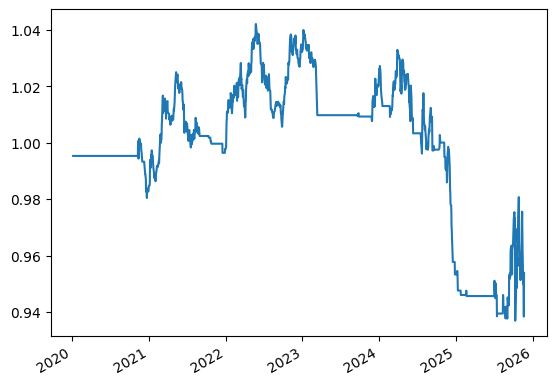

In [14]:
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1. Simple backtest utilities
# -------------------------------------------------------

def compute_cagr(returns, freq=252):
    """Compound annual growth rate from a return series."""
    cum = (1 + returns).prod()
    n_periods = len(returns)
    if n_periods == 0 or cum <= 0:
        return np.nan
    years = n_periods / freq
    return cum ** (1 / years) - 1


def compute_max_drawdown(cum_curve):
    """Max drawdown from a cumulative return curve (not log)."""
    running_max = cum_curve.cummax()
    dd = cum_curve / running_max - 1
    return dd.min()


def backtest_trend_factor(
    factor_ret: pd.Series,
    lookback: int = 126,
    side: str = "long_flat",
):
    """
    Time-series trend rule on a single factor.

    - factor_ret: daily factor returns (index = dates)
    - lookback: rolling window in days (e.g. 126 ~ 6 months)
    - side:
        "long_flat": +1 when lookback return > 0, else 0
        "long_short": +1 when lookback return > 0, else -1
    """
    factor_ret = factor_ret.dropna()
    # rolling cumulative return over lookback window
    roll_ret = (1 + factor_ret).rolling(lookback).apply(np.prod, raw=True) - 1

    if side == "long_flat":
        signal = (roll_ret > 0).astype(float)
    elif side == "long_short":
        signal = np.where(roll_ret > 0, 1.0, -1.0)
        signal = pd.Series(signal, index=factor_ret.index)
    else:
        raise ValueError("side must be 'long_flat' or 'long_short'")

    # align signal with factor returns (shift to avoid look-ahead)
    signal = signal.shift(1).fillna(0.0)
    strat_ret = signal * factor_ret

    cum = (1 + strat_ret).cumprod()

    cagr = compute_cagr(strat_ret)
    vol = strat_ret.std() * np.sqrt(252)
    sharpe = cagr / vol if vol > 0 else np.nan
    mdd = compute_max_drawdown(cum)

    stats = {
        "CAGR": cagr,
        "Vol": vol,
        "Sharpe": sharpe,
        "MaxDrawdown": mdd,
    }
    return strat_ret, cum, stats


# -------------------------------------------------------
# 2. Build factor trends & backtests from your model
# -------------------------------------------------------

def build_factor_trend_backtests(
    excel_path: str,
    lookback: int = 126,
    side: str = "long_flat",
):
    """
    Uses your Kakushadze-style model to:
      - get factor return series
      - create a synthetic 'Market' factor
      - backtest trend strategies on selected factors.

    Returns a dict with:
      - 'stats': DataFrame (factors × metrics)
      - 'strat_returns': dict of Series per factor
      - 'cum_curves': dict of Series per factor
    """
    # assumes build_etf_risk_model is defined above / imported
    model = build_etf_risk_model(excel_path)

    factor_returns = model["factor_returns"]   # K × T (rows=factors, cols=dates)
    etf_returns = model["returns"]             # N × T (rows=ETFs, cols=dates)

    # Create a simple 'Market' factor as equal-weight of all ETFs
    market_ret = etf_returns.mean(axis=0)
    market_ret.name = "Market"

    # Put market into factor return panel
    fr = factor_returns.copy()
    fr.loc["Market"] = market_ret

    # pick the factors you care about
    factors_of_interest = [
        "Style_Growth",
        "Style_Value",
        "Style_Blend",
        "Style_Income",
        "Style_Core",
        "Market",
    ]

    # keep only those that actually exist in the model
    factors_of_interest = [f for f in factors_of_interest if f in fr.index]

    stats_list = []
    strat_returns = {}
    cum_curves = {}

    for fac in factors_of_interest:
        fac_ret = fr.loc[fac].sort_index()
        strat_ret, cum, stats = backtest_trend_factor(
            fac_ret, lookback=lookback, side=side
        )
        strat_returns[fac] = strat_ret
        cum_curves[fac] = cum

        stats_row = {"Factor": fac}
        stats_row.update(stats)
        stats_list.append(stats_row)

    stats_df = pd.DataFrame(stats_list).set_index("Factor")
    return {
        "stats": stats_df,
        "strat_returns": strat_returns,
        "cum_curves": cum_curves,
    }

    R = model["returns"]                 # N x T, rows = ETFs, cols = dates
    w = pd.Series({
    
        "CERY US Equity": 0.03,
        "EBND US Equity": 0.015,
        "EMHC US Equity": 0.03,
        "FISR US Equity": 0.105,
        "GLD US Equity": 0.03,
        "GWX US Equity": 0.02,
        "JNK US Equity": 0.01,
        "N/A US Equity": 0.02,
        "SPAB US Equity": 0.0225,
        "SPDW US Equity": 0.11,
        "SPEM US Equity": 0.085,
        "SPLB US Equity": 0.01,
        "SPMD US Equity": 0.025,
        "SPSM US Equity": 0.045,
        "SPTL US Equity": 0.05,
        "SPY US Equity": 0.235,
        "SRLN US Equity": 0.025,
        "TIPX US Equity": 0.02,
        "XLSR US Equity": 0.135
    }) # replace with your own weights if needed
    
    port_ret = (R.T @ w)                 # Series by date
    port_ret.name = "Portfolio"
    port_curve = (1 + port_ret).cumprod()
    
    # --- 2) Compute stats for the portfolio ---
    port_cagr = compute_cagr(port_ret)
    port_vol  = port_ret.std() * np.sqrt(252)
    port_sharpe = port_cagr / port_vol if port_vol > 0 else np.nan
    port_mdd  = compute_max_drawdown(port_curve)
    
    port_stats = pd.Series(
        {
            "CAGR": port_cagr,
            "Vol": port_vol,
            "Sharpe": port_sharpe,
            "MaxDrawdown": port_mdd,
        },
        name="Portfolio",
    )

# --- 3) Append to the factor stats table and print ---

    stats_with_port = pd.concat([results["stats"], port_stats.to_frame().T])
    print("Trend strategy stats by factor (plus portfolio):")
    print(stats_with_port)
# -------------------------------------------------------
# 3. Example usage
# -------------------------------------------------------
if __name__ == "__main__":
    excel_path = r"/Users/gevorghakobyan/Downloads/ETF1_chcystxn.xlsx"  # <- change to your path

    # 6-month (126-day) long/flat trend on each factor
    results = build_factor_trend_backtests(
        excel_path,
        lookback=126,
        side="long_flat",
    )

    print("Trend strategy stats by factor:")
    print(results["stats"])
    
    results["cum_curves"]["Style_Value"].loc["2020-01-01":].plot()

    



Missing in R: {'SPAB US Equity', 'SPSM US Equity', 'SPDW US Equity', 'SPMD US Equity', 'EMHC US Equity', 'GWX US Equity', 'JNK US Equity', 'SPEM US Equity', 'SRLN US Equity', 'CERY US Equity', 'TIPX US Equity', 'SPTL US Equity', 'SPLB US Equity', 'EBND US Equity', 'FISR US Equity', 'GLD US Equity', 'N/A US Equity'}


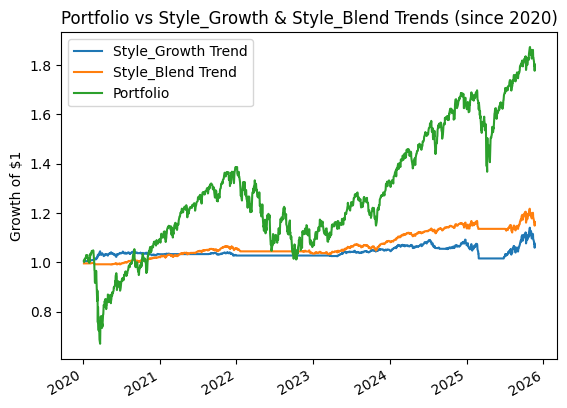

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) ETF return matrix from the model (N x T)
R = model["returns"]

# 2) Portfolio weights (example: equal weight)
raw_w = pd.Series({

    "CERY US Equity": 0.03,
    "EBND US Equity": 0.015,
    "EMHC US Equity": 0.03,
    "FISR US Equity": 0.105,
    "GLD US Equity": 0.03,
    "GWX US Equity": 0.02,
    "JNK US Equity": 0.01,
    "N/A US Equity": 0.02,
    "SPAB US Equity": 0.0225,
    "SPDW US Equity": 0.11,
    "SPEM US Equity": 0.085,
    "SPLB US Equity": 0.01,
    "SPMD US Equity": 0.025,
    "SPSM US Equity": 0.045,
    "SPTL US Equity": 0.05,
    "SPY US Equity": 0.235,
    "SRLN US Equity": 0.025,
    "TIPX US Equity": 0.02,
})

# check which names are missing / mismatched
print("Missing in R:", set(raw_w.index) - set(R.index))

# 3) Align to R.index and fill missing with 0, then renormalize to 100%
w = raw_w.reindex(R.index).fillna(0.0)
w = w / w.sum()

# 3) Portfolio daily returns & equity curve
port_ret = (R.T @ w)              # Series by date
port_ret.name = "Portfolio"
port_curve = (1 + port_ret).cumprod()

# 4) Factor trend curves from backtest
growth_curve = results["cum_curves"]["Style_Growth"]
blend_curve  = results["cum_curves"]["Style_Blend"]

# 5) Combine all three, align dates, and cut to 2020+
df = pd.concat(
    [growth_curve, blend_curve, port_curve],
    axis=1,
    join="inner"
)
df.columns = ["Style_Growth Trend", "Style_Blend Trend", "Portfolio"]
df = df.loc["2020-01-01":]

# 6) Plot
df.plot()
plt.ylabel("Growth of $1")
plt.title("Portfolio vs Style_Growth & Style_Blend Trends (since 2020)")
plt.show()
